# 6 gestures classification

This file contains code for deep learning model capable of classification of 6 different hand gestures based on black and white hand masks. Model share sample principles as described in 20_gestures_recognition.

In [1]:
import numpy as np
from PIL import Image
import imageio.v2 as imageio
import os

In [2]:
import albumentations as A
import cv2

In [11]:
from sklearn.model_selection import train_test_split

In [127]:
#X = np.array([Image.fromarray(imageio.imread(f"training_images\\{image}", pilmode="1")).resize((64, 64)) for image in os.listdir("D:\\Zadania\\FingerDigits\\training_images")])

In [128]:
#np.save("masks", X) 

In [143]:
#X.shape

(60030, 64, 64)

In [3]:
X = np.load("masks.npy")

In [4]:
labels = np.array([list(f)[-5] for f in os.listdir("D:\\Zadania\\FingerDigits\\training_images")], dtype=np.int8)

In [5]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels, num_classes=6)

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, LSTM, Concatenate, Reshape, GlobalAveragePooling2D, Dropout, BatchNormalization, RandomRotation, RandomTranslation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
datagen = ImageDataGenerator(
    rotation_range=80,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant'
)

In [55]:
X_train.shape

(9604, 64, 64, 1)

In [15]:
import keras
from keras.callbacks import Callback
import os

class SaveBestWeights(Callback):
    def __init__(self, filepath):
        super(SaveBestWeights, self).__init__()
        self.filepath = filepath
        self.best_loss = float('inf')
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_loss = logs.get('loss')
        current_val_loss = logs.get('val_loss')
        
        # Check if both training loss and validation loss are lower than the previous bests
        if current_loss <= self.best_loss and current_val_loss <= self.best_val_loss:
            self.best_loss = current_loss
            self.best_val_loss = current_val_loss
            print(f"\nEpoch {epoch+1}: Saving model weights with loss={current_loss:.4f} and val_loss={current_val_loss:.4f}")
            self.model.save_weights(self.filepath)

save_callback = SaveBestWeights(filepath='fingerNumbers.weights.h5')

In [9]:
from keras.layers import BatchNormalization, Dropout, LayerNormalization, Add, MultiHeadAttention
def attention_block(x):
    query = Dense(x.shape[-1])(x)
    key = Dense(x.shape[-1])(x)
    value = Dense(x.shape[-1])(x)
    attention_output = MultiHeadAttention(num_heads=3, key_dim=x.shape[-1])(query, key, value)
    attention_output = Add()([x, attention_output])
    attention_output = LayerNormalization()(attention_output)
    return attention_output

input_layer = Input(shape=(64, 64, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = attention_block(x)

x = GlobalAveragePooling2D()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)

output_layer = Dense(6, activation='softmax')(x)

model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16, 16,    │     16,512 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16, 16,    │     16,512 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16, 16,    │     16,512 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 16,    │    197,888 │ dense[0][0],      │
│ (MultiHeadAttentio… │ 128)              │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 16,    │          0 │ conv2d_2[0][0],   │
│                     │ 128)              │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 16, 16,    │        256 │ add[0][0]         │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dropout_2[0][0] 

 Total params: 351,318 (1.34 MB)

 Trainable params: 351,318 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(np.expand_dims(X, axis=-1), y, test_size=0.2)

In [13]:
X_train.shape

(9604, 64, 64, 1)

In [14]:
X_val.shape

(2402, 64, 64, 1)

In [20]:
batch_size = 32
steps_per_epoch = X_train.shape[0] // batch_size
model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=1000, 
                                 steps_per_epoch = steps_per_epoch, validation_data=(X_val, y_val),
                                 verbose=1, 
                                 shuffle=True, callbacks=[save_callback]
)

Epoch 1/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 93s 310ms/step - accuracy: 0.9932 - loss: 0.0312 - val_accuracy: 1.0000 - val_loss: 3.2186e-04
Epoch 2/1000
  1/300 ━━━━━━━━━━━━━━━━━━━━ 1:11 238ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 2: Saving model weights with loss=0.0025 and val_loss=0.0003
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 3.2084e-04
Epoch 3/1000
121/300 ━━━━━━━━━━━━━━━━━━━━ 50s 283ms/step - accuracy: 0.9970 - loss: 0.0145

KeyboardInterrupt: 

In [21]:
model.load_weights("fingerNumbers.weights.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1


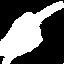

---------

4


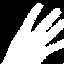

---------

1


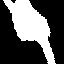

---------

0


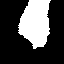

---------

0


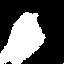

---------

1


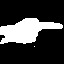

---------

3


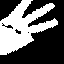

---------

0


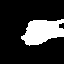

---------

2


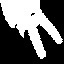

---------

0


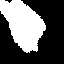

---------

5


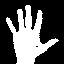

---------



In [32]:
imgs = np.array([Image.fromarray(imageio.imread(f"test{i}.png", pilmode="1")).resize((64, 64)) for i in range(11)])
p = model.predict(imgs)
for i in range(11):
    im = Image.fromarray(imageio.imread(f"test{i}.png", pilmode="1")).resize((64, 64))
    print(np.argmax(p[i]))
    display(im)
    print("---------\n")